# Chapter 9: Project 1: A/B testing


In [1]:
# Importing Packages and Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.155)    
# Calculation of the required sample size
required_sample_size = sms.NormalIndPower().solve_power(effect_size, alpha=0.05, power=0.8, ratio=1)
required_sample_size = np.ceil(required_sample_size)                          
print(required_sample_size)


3064.0


In [2]:
df = pd.read_csv('ab_data.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
6,679687,26:46.9,treatment,new_page,1
7,719014,48:29.5,control,old_page,0
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1


In [3]:
# Computing cross tabulation or frequency table of groups. 
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [4]:
# Checking users who appear multiple times in the dataset. 
num_sessions = df['user_id'].value_counts()
user_mul_times = num_sessions[num_sessions > 1].count()

print('There are %s users that appear multiple times in the dataset' %user_mul_times)


There are 3894 users that appear multiple times in the dataset


In [5]:
remove_users = num_sessions[num_sessions > 1].index

df = df[~df['user_id'].isin(remove_users)]
print(f'''The updated dataset has {df.shape[0]} observations
      after we have removed the users who appear multiple times.''')

The updated dataset has 286690 observations
      after we have removed the users who appear multiple times.


In [61]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [6]:
control_sample = df[df['group'] == 'control'].sample(n=int(required_sample_size), random_state=5)
treatment_sample = df[df['group'] == 'treatment'].sample(n=int(required_sample_size), random_state=5)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.info()

print('\n \n')
ab_test['group'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6128 entries, 0 to 6127
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       6128 non-null   int64 
 1   timestamp     6128 non-null   object
 2   group         6128 non-null   object
 3   landing_page  6128 non-null   object
 4   converted     6128 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 239.5+ KB

 



treatment    3064
control      3064
Name: group, dtype: int64

In [7]:
conversion_rates = ab_test.groupby('group')['converted']
# Std. deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)             
# Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.4f}')



d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
d:\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,conversion_rate,std_deviation,std_error
group,,,
control,0.1237,0.3292,0.0059
treatment,0.1270,0.3329,0.0060


Text(0, 0.5, 'Converted (proportion)')

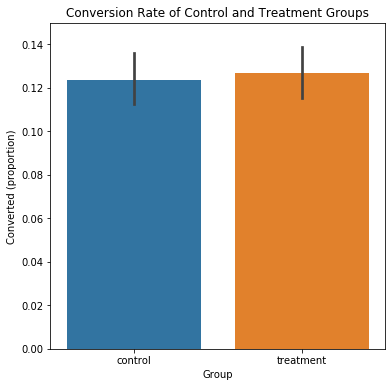

In [8]:
# plotting the results
plt.figure(figsize=(6,6))
sns.barplot(x=ab_test['group'], y=ab_test['converted'])

plt.ylim(0, 0.15)
plt.title('Conversion Rate of Control and Treatment Groups')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)')

In [9]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
converted_control = ab_test[ab_test['group'] == 'control']['converted']
converted_treatment = ab_test[ab_test['group'] == 'treatment']['converted']


n_control = converted_control.count()
n_treatment = converted_treatment.count()
successes = [converted_control.sum(), converted_treatment.sum()]
nobs = [n_control, n_treatment]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: -0.39
p-value: 0.700
95% confidence interval for control group: [0.112, 0.135]
95% confidence interval for treatment group: [0.115, 0.139]
